In [128]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
train_dir = '/content/drive/MyDrive/buetpaper/train'
validation_dir = '/content/drive/MyDrive/buetpaper/val'
test_dir='/content/drive/MyDrive/buetpaper/test'

In [130]:
import os
trainclass_subset=os.listdir(train_dir)
validclass_subset =os.listdir(validation_dir)

In [131]:
trainclass_subset

['Stemborer',
 'Brown_Spot',
 'Neck_Blast',
 'BLB',
 'Healthy_Plant',
 'Hispa',
 'BPH',
 'Sheath_Blight_Rot',
 'False_Smut']

In [132]:
validclass_subset

['False_Smut',
 'BLB',
 'Sheath_Blight_Rot',
 'Neck_Blast',
 'BPH',
 'Stemborer',
 'Healthy_Plant',
 'Brown_Spot',
 'Hispa']

In [133]:
import tensorflow 
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

# **Train Data with simple CNN**

In [134]:
#image preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)
test_datagen = ImageDataGenerator(
    rescale=1./255,
)


In [135]:
# load train data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    color_mode="rgb",
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                   )
#load val data
val_generator = val_datagen.flow_from_directory(validation_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  color_mode="rgb",
                                                  shuffle=False,
                                                  class_mode='categorical',
                                                  )
# load test data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  color_mode="rgb",
                                                  shuffle=False,
                                                  class_mode='categorical',
                                                  )

Found 994 images belonging to 9 classes.
Found 208 images belonging to 9 classes.
Found 224 images belonging to 9 classes.


# **Train with InceptionV3**

In [136]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Input, Reshape, Concatenate, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation, GlobalMaxPooling2D
from tensorflow.keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [137]:
inception = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")


9420800/9406464 [==============================] - 0s 0us/step


In [138]:
#do not train the pre-trained layers of VGG-19
for layer in inception.layers:
    layer.trainable = False

In [139]:
x = inception.output
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
output_layer = Dense(9, activation='softmax', name='softmax')(x)
model = Model(inputs=inception.input, outputs=output_layer)
   

In [140]:
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [141]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f0a759c0310> False
<keras.layers.convolutional.Conv2D object at 0x7f07d1627f10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f09ab284a50> False
<keras.layers.advanced_activations.ReLU object at 0x7f09ab2996d0> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f07d16a1110> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0b14f1da10> False
<keras.layers.advanced_activations.ReLU object at 0x7f07d16377d0> False
<keras.layers.convolutional.Conv2D object at 0x7f07d15e99d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f07d1637350> False
<keras.layers.convolutional.Conv2D object at 0x7f07d1588690> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f07d15fc850> False
<keras.layers.advanced_activations.ReLU object at 0x7f07d1596590> False
<keras.layers.convolutional.ZeroPadding2D 

In [142]:
from keras.optimizer_v1 import Adam
EPOCHS=30
model.compile(loss="categorical_crossentropy", optimizer="Adam",metrics=["accuracy"])

In [143]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)


In [144]:
modelcheck = ModelCheckpoint('/content/gdrive/MyDrive/best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)


In [145]:
history = model.fit_generator(train_generator,validation_data=val_generator,epochs=EPOCHS,verbose=1,callbacks=[es])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/30
32/32 [==============================] - 17s 439ms/step - loss: 6.3755 - accuracy: 0.4125 - val_loss: 2.0885 - val_accuracy: 0.6731
Epoch 2/30
32/32 [==============================] - 13s 413ms/step - loss: 1.3609 - accuracy: 0.7404 - val_loss: 1.0222 - val_accuracy: 0.8077
Epoch 3/30
32/32 [==============================] - 14s 426ms/step - loss: 0.8693 - accuracy: 0.8239 - val_loss: 0.5522 - val_accuracy: 0.8846
Epoch 4/30
32/32 [==============================] - 13s 414ms/step - loss: 0.6039 - accuracy: 0.8722 - val_loss: 0.4938 - val_accuracy: 0.8846
Epoch 5/30
32/32 [==============================] - 13s 413ms/step - loss: 0.3103 - accuracy: 0.9145 - val_loss: 0.6255 - val_accuracy: 0.8750
Epoch 6/30
32/32 [==============================] - 13s 411ms/step - loss: 0.2167 - accuracy: 0.9406 - val_loss: 0.3025 - val_accuracy: 0.8990
Epoch 7/30
32/32 [==============================] - 13s 413ms/step - loss: 0.2017 - accuracy: 0.9467 - val_loss: 0.2325 - val_accuracy: 0.9519

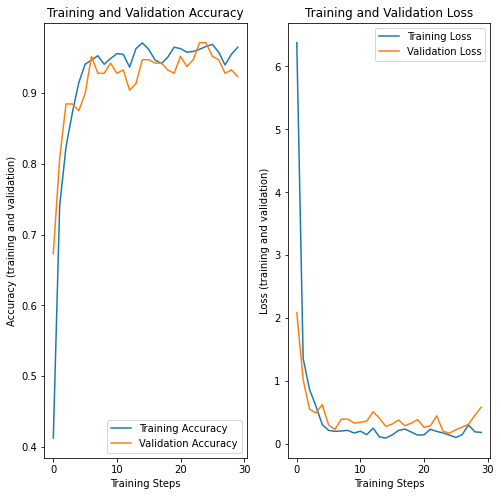

In [146]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [147]:
model.save("/content/drive/MyDrive/VGG16/DenseNetFT.h5")

In [148]:
loss_val, acc_val = model.evaluate(val_generator, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

7/7 [==============================] - 1s 87ms/step - loss: 0.5848 - accuracy: 0.9231
Validation: accuracy = 0.923077  ;  loss_v = 0.584815


In [149]:
loss_test, acc_test = model.evaluate(test_generator, verbose=1)
print("Test: accuracy = %f  ;  loss_v = %f" % (acc_test, loss_test))

7/7 [==============================] - 1s 101ms/step - loss: 0.5599 - accuracy: 0.9241
Test: accuracy = 0.924107  ;  loss_v = 0.559948


In [150]:
loss_train, acc_train = model.evaluate(train_generator, verbose=1)
print("Train: accuracy = %f  ;  loss_v = %f" % (acc_train, loss_train))

32/32 [==============================] - 13s 408ms/step - loss: 0.1577 - accuracy: 0.9608
Train: accuracy = 0.960765  ;  loss_v = 0.157744


# **Image prediction**

**Test Data Confusion matrix & Classification report**

In [151]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.models import load_model
%matplotlib inline
import matplotlib.pyplot as plt

In [152]:
pred_test = model.predict_generator(test_generator)
pred_test = np.argmax(pred_test, axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [153]:
#Confution Matrix and Classification Report
print('Classification Report')
target_names = ['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer']
print(classification_report(test_generator.classes, pred_test, target_names=target_names))

Classification Report
                   precision    recall  f1-score   support

              BLB       0.91      0.91      0.91        22
              BPH       0.79      0.92      0.85        12
       Brown_Spot       1.00      0.94      0.97        18
       False_Smut       0.93      0.93      0.93        15
    Healthy_Plant       0.97      0.94      0.96        36
            Hispa       0.92      0.92      0.92        12
       Neck_Blast       1.00      0.89      0.94        44
Sheath_Blight_Rot       0.97      0.88      0.92        34
        Stemborer       0.79      1.00      0.89        31

         accuracy                           0.92       224
        macro avg       0.92      0.93      0.92       224
     weighted avg       0.93      0.92      0.93       224



In [154]:
test_confusion_matrix = confusion_matrix(test_generator.classes, pred_test)
test_confusion_matrix

array([[20,  0,  0,  0,  0,  0,  0,  0,  2],
       [ 0, 11,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0, 17,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0, 14,  0,  0,  0,  0,  1],
       [ 0,  1,  0,  0, 34,  0,  0,  1,  0],
       [ 0,  1,  0,  0,  0, 11,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0, 39,  0,  4],
       [ 1,  1,  0,  1,  0,  0,  0, 30,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 31]])

In [155]:
test_sum=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
for i in range(9):
    for j in range(9):
        test_sum[i]=test_sum[i]+test_confusion_matrix[i][j]

In [156]:
test_confusion_matrix_percentage = test_confusion_matrix.astype(np.float32)

In [157]:
for i in range(9):
    for j in range(9):
        test_confusion_matrix_percentage[i][j]=test_confusion_matrix_percentage[i][j]/test_sum[i]

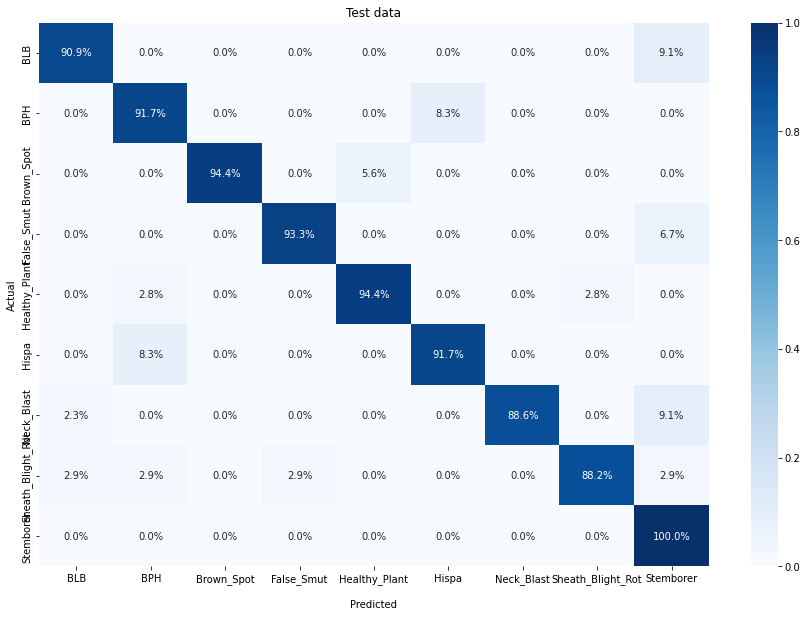

In [158]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(test_confusion_matrix_percentage, annot=True, 
            fmt='.1%', cmap='Blues')

ax.set_title('Test data');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])
ax.yaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Validation Data Confusion matrix and classification report**

In [159]:
pred_val = model.predict_generator(val_generator)
pred_val = np.argmax(pred_val, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [160]:
#Confution Matrix and Classification Report
print('Classification Report')
target_names = ['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer']
print(classification_report(val_generator.classes, pred_val, target_names=target_names))

Classification Report
                   precision    recall  f1-score   support

              BLB       0.86      0.90      0.88        20
              BPH       0.91      1.00      0.95        10
       Brown_Spot       0.84      1.00      0.91        16
       False_Smut       1.00      0.69      0.82        13
    Healthy_Plant       0.85      1.00      0.92        35
            Hispa       1.00      0.60      0.75        10
       Neck_Blast       1.00      0.95      0.98        42
Sheath_Blight_Rot       1.00      0.88      0.93        32
        Stemborer       0.91      1.00      0.95        30

         accuracy                           0.92       208
        macro avg       0.93      0.89      0.90       208
     weighted avg       0.93      0.92      0.92       208



In [161]:
val_confusion_matrix = confusion_matrix(val_generator.classes, pred_val)
val_confusion_matrix

array([[18,  0,  0,  0,  1,  0,  0,  0,  1],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 16,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  9,  1,  0,  0,  0,  1],
       [ 0,  0,  0,  0, 35,  0,  0,  0,  0],
       [ 2,  1,  0,  0,  1,  6,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0, 40,  0,  1],
       [ 0,  0,  1,  0,  3,  0,  0, 28,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 30]])

In [162]:
val_sum=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
for i in range(9):
    for j in range(9):
        val_sum[i]=val_sum[i]+val_confusion_matrix[i][j]
        
        
val_confusion_matrix_percentage = val_confusion_matrix.astype(np.float32)

for i in range(9):
    for j in range(9):
        val_confusion_matrix_percentage[i][j]=val_confusion_matrix_percentage[i][j]/val_sum[i]


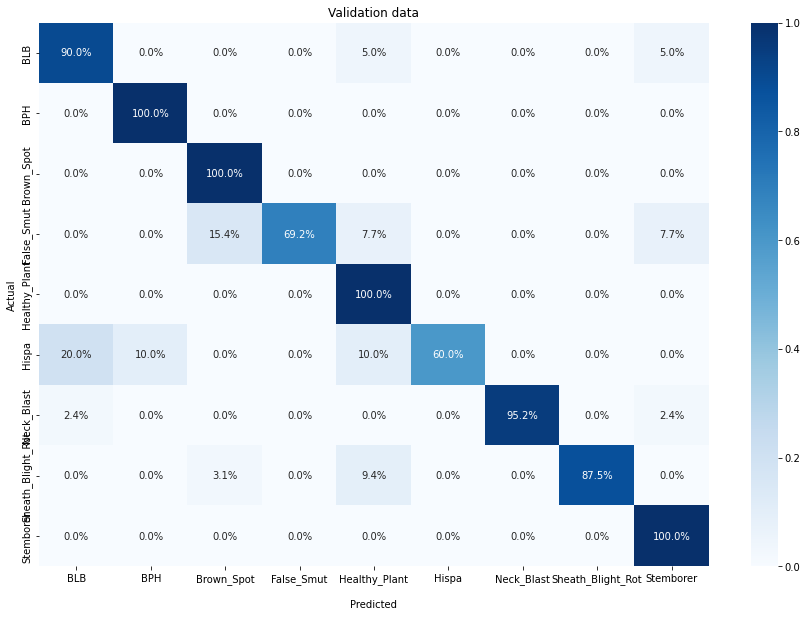

In [163]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(val_confusion_matrix_percentage, annot=True, 
            fmt='.1%', cmap='Blues')

ax.set_title('Validation data');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])
ax.yaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Train Data Confusion matrix & Classification report**


In [164]:
train_dir = '/content/drive/MyDrive/buetpaper/train'

In [165]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    color_mode="rgb",
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                   )

Found 994 images belonging to 9 classes.


In [166]:
model=load_model('/content/drive/MyDrive/VGG16/DenseNetFT.h5')

In [167]:
pred_train = model.predict_generator(train_generator)
pred_train = np.argmax(pred_train, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [168]:
#Confution Matrix and Classification Report
print('Classification Report')
target_names = ['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer']
print(classification_report(train_generator.classes, pred_train, target_names=target_names))

Classification Report
                   precision    recall  f1-score   support

              BLB       0.95      1.00      0.97        96
              BPH       0.94      1.00      0.97        49
       Brown_Spot       1.00      0.99      0.99        77
       False_Smut       1.00      0.91      0.95        65
    Healthy_Plant       0.96      1.00      0.98       163
            Hispa       1.00      0.86      0.93        51
       Neck_Blast       1.00      0.94      0.97       200
Sheath_Blight_Rot       1.00      0.99      0.99       153
        Stemborer       0.92      1.00      0.96       140

         accuracy                           0.97       994
        macro avg       0.97      0.96      0.97       994
     weighted avg       0.97      0.97      0.97       994



In [169]:
train_confusion_matrix = confusion_matrix(train_generator.classes, pred_train)
train_confusion_matrix

array([[ 96,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  49,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,  76,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,  59,   3,   0,   0,   0,   2],
       [  0,   0,   0,   0, 163,   0,   0,   0,   0],
       [  1,   3,   0,   0,   3,  44,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0, 188,   0,  11],
       [  1,   0,   0,   0,   1,   0,   0, 151,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 140]])

In [170]:
train_sum=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
for i in range(9):
    for j in range(9):
        train_sum[i]=train_sum[i]+train_confusion_matrix[i][j]
        
        
train_confusion_matrix_percentage = train_confusion_matrix.astype(np.float32)

for i in range(9):
    for j in range(9):
        train_confusion_matrix_percentage[i][j]=train_confusion_matrix_percentage[i][j]/train_sum[i]


In [171]:
train_sum

array([ 96,  49,  77,  65, 163,  51, 200, 153, 140])

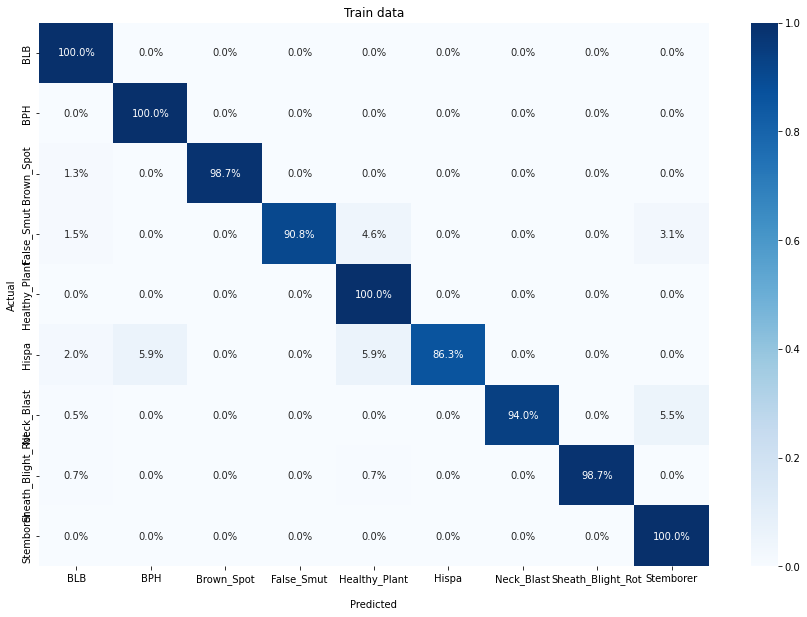

In [172]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(train_confusion_matrix_percentage, annot=True, 
            fmt='.1%', cmap='Blues')

ax.set_title('Train data');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])
ax.yaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])

## Display the visualization of the Confusion Matrix.
plt.show()